# About YOLOv3
[YOLO](https://pjreddie.com/darknet/yolo/) is a real-time object detection model. We are gonna use it's implementation in Keras and run it as a service with TensorFlow-Serving.

Steps to take:
1. Create the model with Keras.
1. Explore the structure (input/output).
1. Test the model.
1. Export the model.
1. Run the server.
1. Test the service.

# Model loading

First we create the ```yolov3.h5``` model using the [keras-yolo3](https://github.com/qqwweee/keras-yolo3) script+config and YOLOv3 weights taken from [here](https://pjreddie.com/media/files/yolov3.weights). The weights were calculated based on the COCO dataset (contains 80 classes). 
Having done that, we can load the model and explore its structure.

In [1]:
import tensorflow as tf
from keras.models import load_model

model = load_model('models/yolov3.h5')

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


/Users/mronacher/anaconda3/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


# Model structure
From what we see below, the model input is a tensor and output is a list of three tensors. The yolo3 model outputs boxes, classes and scores.

In [2]:
print('Graph input tensor: \n', model.input) # get input tensor name and shape
print('Graph output tensor: \n', model.output) # get output tensor name and shape
model.summary()

Graph input tensor: 
 Tensor("input_1:0", shape=(?, ?, ?, 3), dtype=float32)
Graph output tensor: 
 [<tf.Tensor 'conv2d_59/BiasAdd:0' shape=(?, ?, ?, 255) dtype=float32>, <tf.Tensor 'conv2d_67/BiasAdd:0' shape=(?, ?, ?, 255) dtype=float32>, <tf.Tensor 'conv2d_75/BiasAdd:0' shape=(?, ?, ?, 255) dtype=float32>]
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 128         conv2d_1[0][0]                

# Model testing
First we load an image.

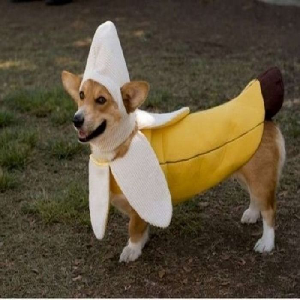

In [3]:
from keras.preprocessing.image import load_img

image_path = 'images/img2.jpg'

input_image = load_img(image_path, target_size=(300,300))
input_image

Then we preprocess it and check it's shape.

In [4]:
from time import time # measure execution time
import numpy as np 
from keras.preprocessing.image import img_to_array

t_start = time()

# load and prepare an image
def load_image_pixels(filename, shape):
    # load the image to get its shape
    image = load_img(filename)
    width, height = image.size
    # load the image with the required size
    image = load_img(filename, target_size=shape)
    # convert to numpy array
    image = img_to_array(image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0
    # add a dimension so that we have one sample
    image = np.expand_dims(image, 0)
    return image, width, height

# define the expected input shape for the model
input_w, input_h = 416, 416
# load and prepare image
image, image_w, image_h = load_image_pixels(image_path, (input_w, input_h))

t_end = time()
print('Excution time: {:1.3f} ms. Tensor shape: {}'.format((t_end-t_start)*1000, image.shape))
# type(image)

Excution time: 29.954 ms. Tensor shape: (1, 416, 416, 3)


Making prediction and checking the output.

In [5]:
t_start = time()

yolo_output = model.predict(image)

t_end = time()

print('Execution time: {:1.3f} ms. Tensors: {}'.format((t_end-t_start)*1000, [a.shape for a in yolo_output]))
#print([type(a) for a in yolo_output])

Execution time: 3346.546 ms. Tensors: [(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]


In [6]:
# yolo_output

Time to interpret the output. I'm going to use [this solution](https://machinelearningmastery.com/how-to-perform-object-detection-with-yolov3-in-keras/), which is a slightly different version of [experiencor's implementation of keras-yolo3](https://github.com/experiencor/keras-yolo3). This approach doesn't require `cv2`.

Known issue: sometimes it's necessary to run the code chunk twice in order to display the image with the boxes.

banana 77.1406888961792
dog 73.33105802536011


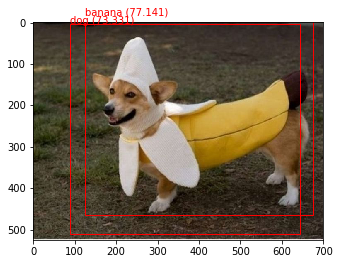

In [8]:
import copy
from utils import *
from matplotlib import pyplot
from matplotlib.patches import Rectangle

# define the anchors
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]

# define COCO classes
classes_path = "models/coco_classes.txt"
with open(classes_path) as f:
    class_names = f.readlines()
labels = [c.strip() for c in class_names]

# define the probability threshold for detected objects for the final output
class_threshold = 0.6

# function decode_netout changes the network output, 
# therefore you can't run this code chunk twice in a row without making a deep copy
netout = copy.deepcopy(yolo_output)

boxes = list()
for i in range(len(netout)):
    # decode the output of the network
    boxes += decode_netout(netout[i][0], anchors[i], class_threshold, input_h, input_w)

# correct the sizes of the bounding boxes for the shape of the image
correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)
# suppress non-maximal boxes
do_nms(boxes, 0.5)

# get all of the results above a threshold
def get_boxes(boxes, labels, thresh):
    v_boxes, v_labels, v_scores = list(), list(), list()
    # enumerate all boxes
    for box in boxes:
        # enumerate all possible labels
        for i in range(len(labels)):
            # check if the threshold for this label is high enough
            if box.classes[i] > thresh:
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i]*100)
                # don't break, many labels may trigger for one box
    return v_boxes, v_labels, v_scores

# get the details of the detected objects
v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)

# draw all results
def draw_boxes(filename, v_boxes, v_labels, v_scores):
    # load the image
    data = pyplot.imread(filename)
    # plot the image
    pyplot.imshow(data)
    # get the context for drawing boxes
    ax = pyplot.gca()
    # plot each box
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        # get coordinates
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        # create the shape
        rect = Rectangle((x1, y1), width, height, fill=False, color='red')
        # draw the box
        ax.add_patch(rect)
        # draw text and score in top left corner
        label = "%s (%.3f)" % (v_labels[i], v_scores[i])
        pyplot.text(x1, y1, label, color='red')
    # show the plot
    pyplot.show()

# draw what we found
for i in range(len(v_labels)):
    print(v_labels[i], v_scores[i])
draw_boxes(image_path, v_boxes, v_labels, v_scores)

In [9]:
# boxes

# Model exporting

In [10]:
from tensorflow.python.saved_model.signature_def_utils_impl import predict_signature_def
from tensorflow.python.saved_model import tag_constants, signature_constants
from tensorflow.python.saved_model import builder as saved_model_builder # protobuffer builder
from tensorflow.keras import backend as K

K.set_learning_phase(0)  # Deactivate train-only-layers like: batch norm and dropout

export_path = 'export/yolov3/1' # The export path contains the name and the version of the model

# building the prediciton signature
sig_input = {'input_image': model.input}
sig_outputs = {t.name: t for t in model.outputs}
signature = predict_signature_def(inputs=sig_input, outputs=sig_outputs)

builder = saved_model_builder.SavedModelBuilder(export_path)
sess = K.get_session()
sess.run(tf.global_variables_initializer())

builder.add_meta_graph_and_variables(sess=sess,
                                     tags=[tag_constants.SERVING], 
                                     signature_def_map={
                                                 'predict':signature
                                     })
builder.save()

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: export/yolov3/1/saved_model.pb


b'export/yolov3/1/saved_model.pb'

Alternative way to export the model taken from [here](https://blog.csdn.net/moshuilangting/article/details/89084624). Doesn't seem to work the moment you request a response though.

In [11]:
# import os
# import os.path as osp
# from keras import backend as K

# def h5_to_pb(h5_model,output_dir,model_name,out_prefix = "output_",log_tensorboard = False):
#     if osp.exists(output_dir) == False:
#         os.mkdir(output_dir)
#     out_nodes = []
#     for i in range(len(h5_model.outputs)):
#         out_nodes.append(out_prefix + str(i + 1))
#         tf.identity(h5_model.output[i],out_prefix + str(i + 1))
#     sess = K.get_session()
#     from tensorflow.python.framework import graph_util,graph_io
#     init_graph = sess.graph.as_graph_def()
#     main_graph = graph_util.convert_variables_to_constants(sess,init_graph,out_nodes)
#     graph_io.write_graph(main_graph,output_dir,name = model_name,as_text = False)
#     if log_tensorboard:
#         from tensorflow.python.tools import import_pb_to_tensorboard
#         import_pb_to_tensorboard.import_to_tensorboard(osp.join(output_dir,model_name),output_dir)

# output_dir = osp.join(os.getcwd(),"export/yolov3/1")

# h5_to_pb(model,output_dir = output_dir,model_name = 'saved_model.pb')

# Server start

Note that the Tensorflow-Serving version is 1.13.0 here.

In [12]:
%%bash
docker run -d -p 8500:8500 \
    --mount type=bind,source=$(pwd)/export/yolov3/,target=/models/yolov3 \
    -e MODEL_NAME=yolov3 \
    --name yolov3_tfserving \
    -t tensorflow/serving:1.13.0 

c1313c2aa81edd5fb23a4756c69e8fed7d16e04a7950fb59ec6f65b64b0242e7


In [13]:
%%bash
docker ps --format "table {{.Names}}\t{{.Image}}\t{{.Ports}}"

NAMES               IMAGE                       PORTS
yolov3_tfserving    tensorflow/serving:1.13.0   0.0.0.0:8500->8500/tcp, 8501/tcp


In [14]:
%%bash
    docker logs yolov3_tfserving

2019-06-07 00:32:39.446298: I tensorflow_serving/model_servers/server.cc:82] Building single TensorFlow model file config:  model_name: yolov3 model_base_path: /models/yolov3
2019-06-07 00:32:39.446929: I tensorflow_serving/model_servers/server_core.cc:461] Adding/updating models.
2019-06-07 00:32:39.447026: I tensorflow_serving/model_servers/server_core.cc:558]  (Re-)adding model: yolov3
2019-06-07 00:32:39.564366: I tensorflow_serving/core/basic_manager.cc:739] Successfully reserved resources to load servable {name: yolov3 version: 1}
2019-06-07 00:32:39.564460: I tensorflow_serving/core/loader_harness.cc:66] Approving load for servable version {name: yolov3 version: 1}
2019-06-07 00:32:39.564503: I tensorflow_serving/core/loader_harness.cc:74] Loading servable version {name: yolov3 version: 1}
2019-06-07 00:32:39.565306: I external/org_tensorflow/tensorflow/contrib/session_bundle/bundle_shim.cc:363] Attempting to load native SavedModelBundle in bundle-shim from: /models/yolov3/1
201

# Service testing

In [15]:
from tensorflow_serving.apis import predict_pb2 
from tensorflow import make_tensor_proto 

request = predict_pb2.PredictRequest()

# fill the protobuffer with model specific data
request.model_spec.name = 'yolov3' # same as directory name inside ./export
request.model_spec.version.value = 1 # same as directory name inside ./export/yolov3'
request.model_spec.signature_name = 'predict'
request.inputs['input_image'].CopyFrom(make_tensor_proto(image, shape=image.shape)) # fill tensor data

#request

In [16]:
import grpc # to create a gRPC client
from tensorflow_serving.apis import prediction_service_pb2_grpc # grpc channel handle

# create a gRPC connection and server stub
channel = grpc.insecure_channel('127.0.0.1:8500') # (if model runs locally)
stub = prediction_service_pb2_grpc.PredictionServiceStub(channel) # instantiate a stub

t_start = time()

# make a gRPC call to the server
response = stub.Predict(request, 100.0)  # 10 secs timeout

t_end = time()

channel.close()

print('Execution time: {:1.3f} ms'.format((t_end-t_start)*1000))
#response

Execution time: 4324.465 ms


In [17]:
tens1 = tf.make_ndarray(response.outputs['conv2d_59/BiasAdd:0'])
tens2 = tf.make_ndarray(response.outputs['conv2d_67/BiasAdd:0'])
tens3 = tf.make_ndarray(response.outputs['conv2d_75/BiasAdd:0'])

serv_outputs = [tens1,tens2,tens3]
print([a.shape for a in serv_outputs])
# print([type(a) for a in serv_outputs])
serv_outputs

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]


[array([[[[-4.89888713e-02,  8.53734743e-03,  1.01045584e-02, ...,
           -1.48044592e-02, -3.36626247e-02,  2.26606466e-02],
          [-5.58439679e-02,  7.89418444e-03,  2.47016456e-03, ...,
           -1.42061347e-02, -4.62889895e-02,  2.77350731e-02],
          [-7.36381710e-02,  1.42852440e-02,  1.73710380e-03, ...,
           -9.61505808e-03, -4.68558073e-02,  3.22299600e-02],
          ...,
          [-4.14644219e-02,  3.45128402e-02, -1.29530206e-04, ...,
           -4.61137947e-03, -3.23702283e-02,  5.52922711e-02],
          [-3.51499394e-02,  3.84623483e-02, -9.43914801e-03, ...,
           -5.98279014e-03, -2.17677876e-02,  3.67927551e-02],
          [-1.45096481e-02,  1.86110418e-02,  2.28346372e-03, ...,
           -2.77661532e-02, -3.27375927e-03,  1.86325610e-02]],
 
         [[-9.56917852e-02,  1.03696063e-03, -9.62348375e-03, ...,
           -1.08196232e-02, -1.99241377e-02,  3.40483151e-04],
          [-1.37858182e-01,  2.91445851e-03, -5.47928065e-02, ...,
     

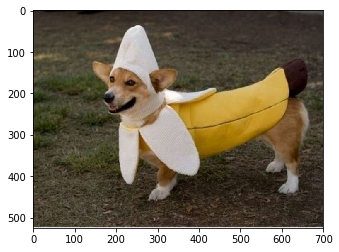

In [18]:
serv_netout = copy.deepcopy(serv_outputs)

serv_boxes = list()
for i in range(len(serv_netout)):
    # decode the output of the network
    serv_boxes += decode_netout(serv_netout[i][0], anchors[i], class_threshold, input_h, input_w)

# correct the sizes of the bounding boxes for the shape of the image
correct_yolo_boxes(serv_boxes, image_h, image_w, input_h, input_w)
# suppress non-maximal boxes
do_nms(serv_boxes, 0.5)

# get the details of the detected objects
serv_v_boxes, serv_v_labels, serv_v_scores = get_boxes(serv_boxes, labels, class_threshold)

# draw what we found
for i in range(len(serv_v_labels)):
    print('test', serv_v_labels[i], serv_v_scores[i])
draw_boxes(image_path, serv_v_boxes, serv_v_labels, serv_v_scores)

In [19]:
# for i in range(len(serv_boxes)):
#     print(serv_boxes[i].classes)